# Dependencies

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data Processing

In [9]:
df_train = pd.read_csv("../files/data/Surface_Crack/RN_TRAIN.csv", index_col=0)
df_train = df_train.drop(columns=['mgfw', 'mg', 'E', 'sigma', 'a'])
df_train = df_train.reindex(['a/c', 'a/t', 'c/b', 'phi', "KI"], axis=1)
d_train = df_train.to_numpy()
df_train, d_train.shape

(         a/c   a/t  c/b       phi         KI
 0       0.90  0.60  0.3  2.120567  34.597826
 1       0.75  0.65  0.3  0.853478  40.001090
 2       1.95  0.30  0.3  1.329954  14.470167
 3       0.90  0.40  0.3  2.979193  29.456790
 4       1.00  0.60  0.3  0.371790  36.227644
 ...      ...   ...  ...       ...        ...
 601662  0.65  0.50  0.3  2.445190  35.095373
 601663  1.80  0.25  0.3  0.037024  20.628363
 601664  0.30  0.65  0.4  0.007405  49.395277
 601665  1.15  0.60  0.3  1.324708  29.393773
 601666  0.55  0.80  0.2  0.413674  52.415671
 
 [601667 rows x 5 columns],
 (601667, 5))

In [10]:
# Get unique combinations of the first four columns
SC_train_combinations = df_train.iloc[:, :3].drop_duplicates().to_numpy()

print(len(SC_train_combinations))

2518


In [11]:
print("Different a/c values: ", np.unique(SC_train_combinations[:,0], axis=0))
print("Different a/t values: ", np.unique(SC_train_combinations[:,1], axis=0))
print("Different c/b values: ", np.unique(SC_train_combinations[:,2], axis=0))

Different a/c values:  [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55
 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
Different a/t values:  [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85]
Different c/b values:  [0.01 0.1  0.2  0.3  0.4 ]


In [ ]:
min_phi = []
max_phi = []

for (i,combination) in enumerate(SC_train_combinations):
    indices = np.where((d_train[:, 0] == combination[0]) & 
                    (d_train[:, 1] == combination[1]) &
                    (d_train[:, 2] == combination[2])) 
    indices = indices[0]
    phis = d_train[indices][:,-2]

    min_phi.append(phis.min())
    max_phi.append(phis.max())

min_phi = np.max(np.unique(min_phi))
max_phi = np.min(np.unique(max_phi))

SC_train_phi_regular_128 = np.linspace(min_phi, max_phi, 132)
d_final = np.zeros((len(SC_train_combinations)*128, 6))
for (i,combination) in enumerate(SC_train_combinations):
    data = np.zeros((128, 6))
    data[:,0] = i
    data[:,1] = combination[0]
    data[:,2] = combination[1]
    data[:,3] = combination[2]
    data[:,4] = SC_train_phi_regular_128[2:-2]
    indices = np.where((d_train[:, 0] == combination[0]) & 
                    (d_train[:, 1] == combination[1]) &
                    (d_train[:, 2] == combination[2])) 
    indices = indices[0]

    phi_vals = d_train[indices][:,-2]
    K_vals = d_train[indices][:,-1]
    phi_idxes = np.argsort(phi_vals)
    
    monotonic_phi_idxes = [phi_idxes[0]]
    prev_phi = phi_vals[phi_idxes[0]]
    for index in phi_idxes[1:]:
        now_phi = phi_vals[index]
        if now_phi > prev_phi:
            monotonic_phi_idxes.append(index)
            prev_phi = phi_vals[index]
    
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

    data[:,5] = interp_func(SC_train_phi_regular_128)[2:-2]

    if np.isnan(data).any():
        print("WARNING: NaN at crack: ", i)

    else:
        d_final[i*128:i*128+128] = data

output_df = pd.DataFrame(d_final, columns=["c_index", "a/c", "a/t", "c/b", "phi", "K-T"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/SURFACE_CRACK.csv", index=False)

# Data Viz

In [13]:
df = pd.read_csv("../files/data/FINAL_CSV/SURFACE_CRACK.csv")
df

,c_index,a/c,a/t,c/b,phi,K-T
0,0.0,0.90,0.6,0.3,0.104098,40.318066
1,0.0,0.90,0.6,0.3,0.127231,39.942442
2,0.0,0.90,0.6,0.3,0.150363,39.589036
3,0.0,0.90,0.6,0.3,0.173496,39.258976
4,0.0,0.90,0.6,0.3,0.196628,38.948442
...,...,...,...,...,...,...
322299,2517.0,1.25,0.7,0.4,2.949401,42.138823
322300,2517.0,1.25,0.7,0.4,2.972534,42.570806
322301,2517.0,1.25,0.7,0.4,2.995667,43.018442
322302,2517.0,1.25,0.7,0.4,3.018799,43.480511


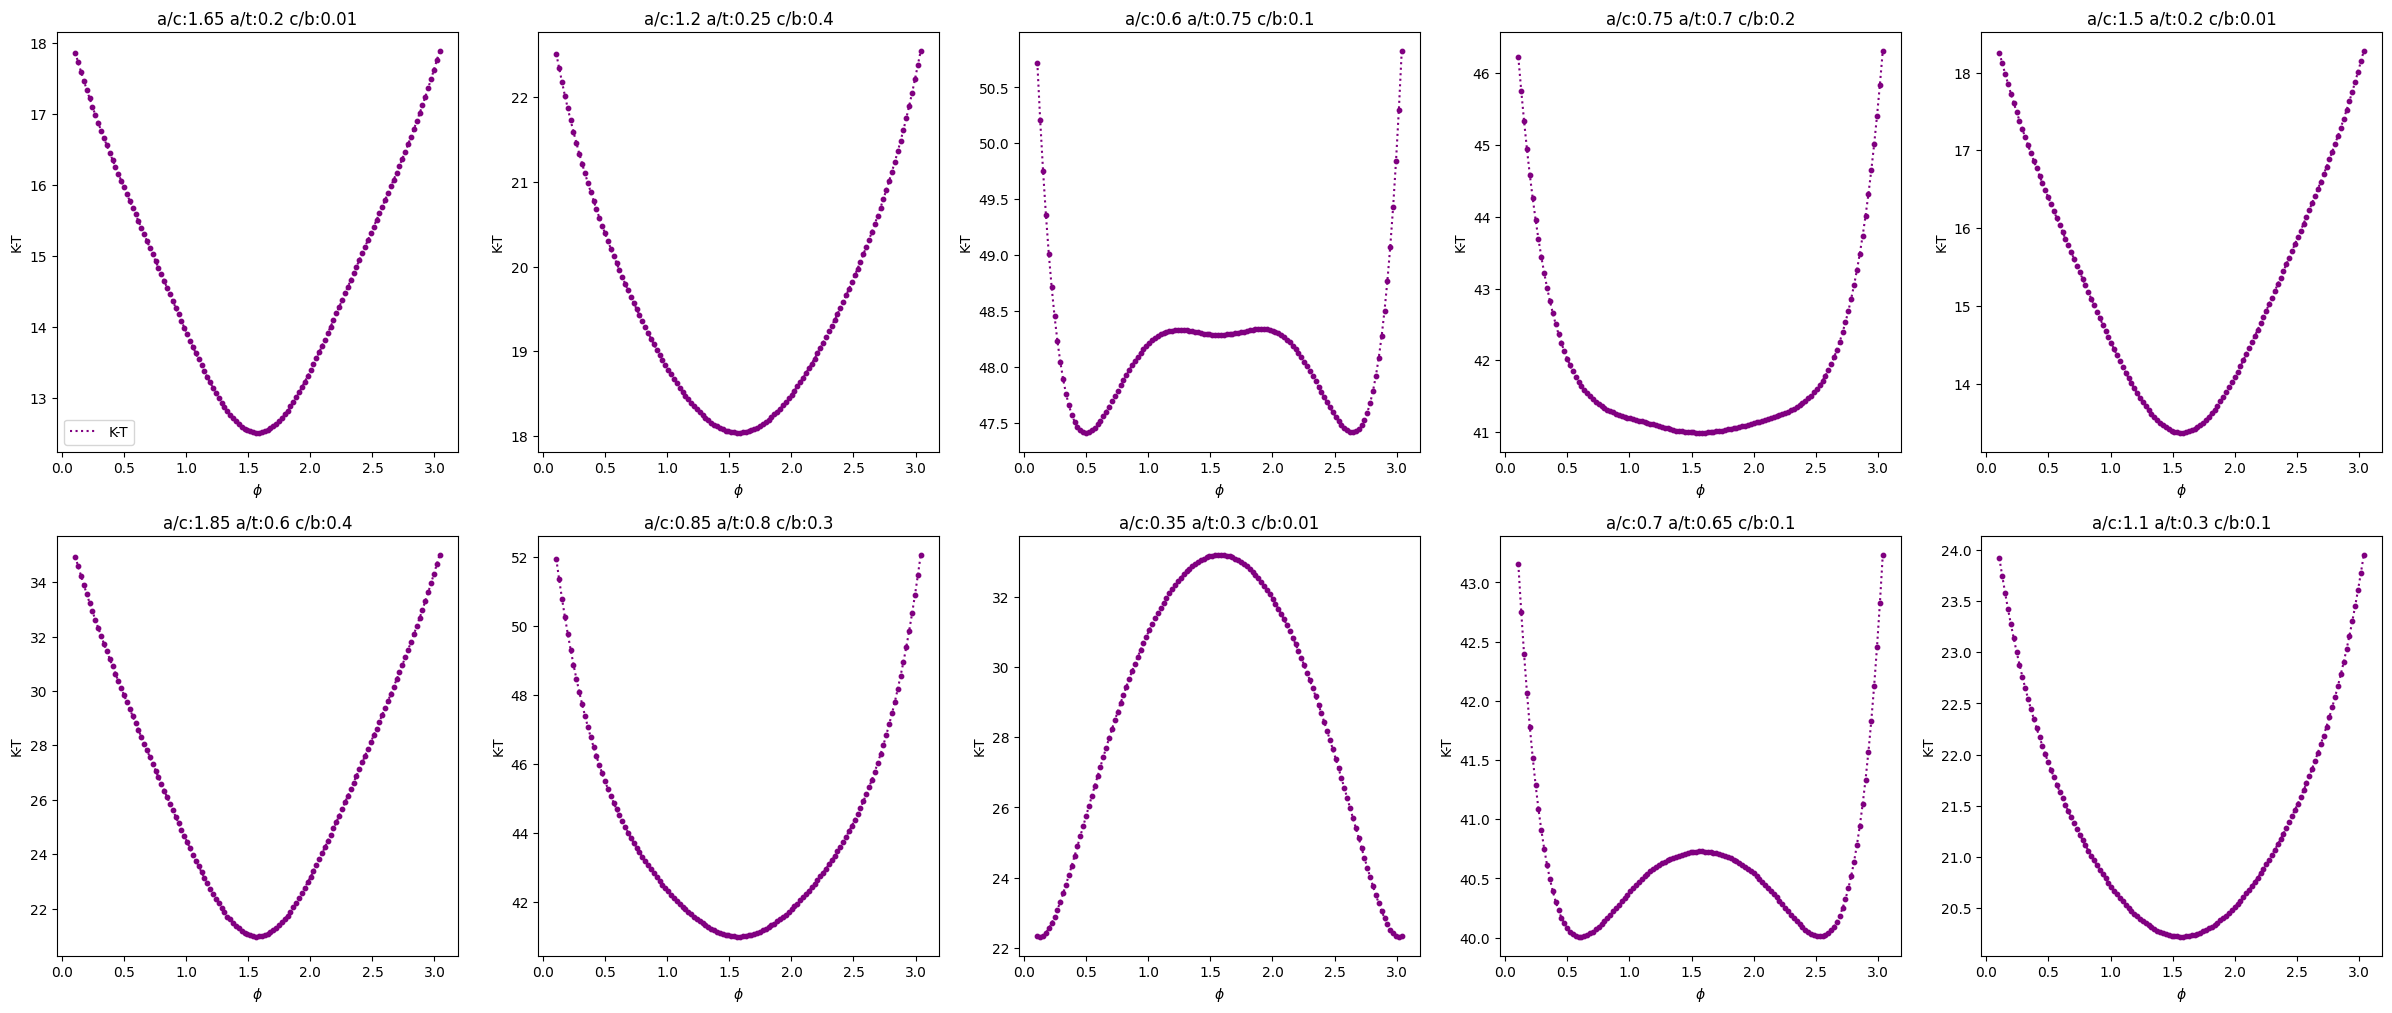

In [19]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        a_c = np.unique(data[:,1])
        a_t = np.unique(data[:,2])
        c_b = np.unique(data[:,3])

        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(c_b) == 1

        axs[i,j].scatter(data[:,-2], data[:,-1], color='purple', s=10)
        axs[i,j].plot(data[:,-2], data[:,-1], label="K-T", color='purple', linestyle=":")

        axs[i,j].set_title("a/c:{} a/t:{} c/b:{}".format(a_c[0], a_t[0], c_b[0]))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()